<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
!pip install mitsuba

In [ ]:
# Import the library using the alias "mi"
import mitsuba as mi
import drjit as dr

# Set the variant of the renderer
mi.set_variant('scalar_rgb')
# Load a scene
scene = mi.load_dict(mi.cornell_box())
# Render the scene
img = mi.render(scene)
# Write the rendered image to an EXR file
mi.Bitmap(img).write('cbox.exr')

In [ ]:
plt.imshow(np.array(img))

Custom sensor plugin

In [1]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
mi.set_variant('scalar_rgb')


In [ ]:
rayd = mi.RayDifferential3f()

In [ ]:
rayd

In [ ]:
scene_dict['sensor']['to_world']

In [ ]:
moep = mi.load_dict(scene_dict['sensor'])

In [ ]:
moep.film().size()[0]

In [50]:
trafo = mi.ScalarTransform4f.look_at(
    origin=[1, 1, 1],
    target=[1, 2, 1],
    up=[0, 0, 1]
)

In [67]:
trafo = mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0])

In [51]:
rayd = mi.RayDifferential3f()
rayd.has_differentials = False
rayd.o = mi.Point3f(0.0,0.0,0.0)
rayd.d = mi.Vector3f(1.0,2.0,3.0)

In [68]:
trafo.transform_affine(rayd)

Ray3f[
  o = [0, 0, 0],
  d = [1, 2, 3],
  maxt = 3.40282e+38,
  time = 0,
]

In [55]:
dr.normalize(rayd.d)

[0.26726123690605164, 0.5345224738121033, 0.8017837405204773]

In [61]:
sensor_dict =     {
        'type': 'pinhole_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'img_dist': 2.5,
        'sen_size': 5.0,
        'pinh_rad': 1.0,
        'film': {'type': 'hdrfilm',
      'width': 256,
      'height': 256,
      'rfilter': {'type': 'gaussian'},
      'pixel_format': 'rgb',
      'component_format': 'float32'},
     'sampler': {'type': 'independent', 'sample_count': 8},
    }
sensor = mi.load_dict(sensor_dict)

In [76]:
trafo.transform_affine(rayd.d)

[1.0, 2.0, 3.0]

In [75]:
sensor.to_world.transform_affine(rayd.d)

[1.0, 2.0, 3.0]

In [77]:
class pinhole_sensor (mi.Sensor):
    def __init__(self, props):
        mi.Sensor.__init__(self, props)
        self.to_world = props['to_world']
        self.img_dist = props['img_dist']
        self.sen_size = props['sen_size']
        self.pinh_rad = props['pinh_rad']
        #self.filmsize = self.film().size()
        self.filmsize = (self.sen_size, self.sen_size)
        
    def sample_ray(self, time, sample1, sample2, sample3, active=True):
        print(f"Sample 1: {sample1}")
        print(f"Sample 2: {sample2}")
        
        return (mi.Ray3f(0.0, 0.0, 1.0), mi.Color3f(1.0, 1.0, 1.0))
    
    def sample_ray_differential(self, time, sample1, sample2, sample3, active=True):
        #print(f"RSample 2: {sample2}")
        #print(f"RSample 3: {sample3}")
        
        rayd = mi.RayDifferential3f()
        rayd.has_differentials = False
        
        rayd.o = mi.Point3f(0.0,0.0,0.0)
        rayd.d = mi.Vector3f(-1.0 * (sample2[0]-0.5) * self.filmsize[0], -1.0 * (sample2[1]-0.5) * self.filmsize[1], self.img_dist)
        rayd.d = dr.normalize(rayd.d)
        
        
        rayd.d = self.to_world.transform_affine(rayd.d)
        
        #print(rayd)
        
        
        
        return (rayd, mi.Color3f(1.0, 1.0, 1.0))
    
    def traverse(self, callback):
        print("traverse called")
        
    def parameters_changed(self, keys):
        print("params changed called")
        
    def sample_direction(self,*args, **kwargs):
        print("sample direction called")
        
    def bbox(self,*args, **kwargs):
        print("bbox called")
    
            
    def to_string(self):
        return ('pinhole_sensor[\n'
                '    img_dist=%s,\n'
                '    sen_size=%s,\n'
                '    pinh_rad=%s,\n'
                ']' % (self.img_dist, self.sen_size, self.pinh_rad))
        

In [78]:

mi.register_sensor("pinhole_sensor", lambda props: pinhole_sensor(props))

In [33]:
scene_dict = mi.cornell_box()


In [27]:
film = scene_dict['sensor']['film']
sampler = scene_dict['sensor']['sampler']
sampler['sample_count'] = 8
scene_dict['sensor'] = {
        'type': 'pinhole_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'img_dist': 0.05,
        'sen_size': 100000.0,
        'pinh_rad': 1.0,
        
    }
scene_dict['sensor']['film']=film
scene_dict['sensor']['sampler']=sampler

In [23]:
scene_dict['sensor']

{'type': 'pinhole_sensor',
 'to_world': [[1, 0, 0, 0],
  [0, 1, 0, 0],
  [0, 0, 1, 0],
  [0, 0, 0, 1]],
 'img_dist': 0.05,
 'sen_size': 1.0,
 'pinh_rad': 1.0,
 'film': {'type': 'hdrfilm',
  'width': 256,
  'height': 256,
  'rfilter': {'type': 'gaussian'},
  'pixel_format': 'rgb',
  'component_format': 'float32'},
 'sampler': {'type': 'independent', 'sample_count': 8}}

In [28]:
scene = mi.load_dict(scene_dict)

In [29]:
img = mi.render(scene)

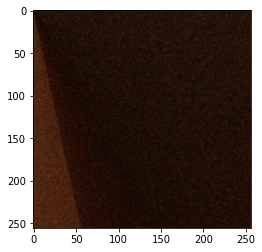

In [21]:
plt.imshow(img)

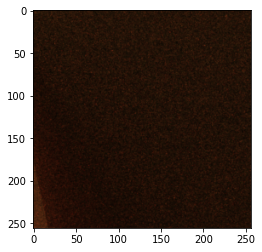

In [26]:
plt.imshow(img)

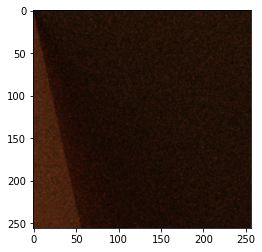

In [30]:
plt.imshow(img)

In [79]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'path'
    },

    'sphere' : {
        'type': 'sphere',
        'emitter': {
            'type': 'area',
            'radiance': {
            'type': 'rgb',
            'value': 1.0,
        },
    },
    'center': [0, 0, 5],
    'radius': 2,
        
    },
    'sensor': {
        'type': 'pinhole_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'img_dist': 2.5,
        'sen_size': 5.0,
        'pinh_rad': 1.0,
        'film': {'type': 'hdrfilm',
      'width': 256,
      'height': 256,
      'rfilter': {'type': 'gaussian'},
      'pixel_format': 'rgb',
      'component_format': 'float32'},
     'sampler': {'type': 'independent', 'sample_count': 8},
    }
})

image = mi.render(scene)

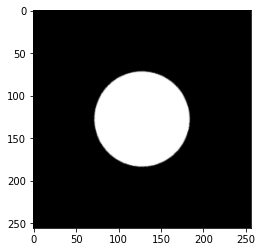

In [48]:
plt.imshow(image)